<a href="https://colab.research.google.com/github/shumshersubashgautam/AI_TRAINING/blob/master/P12_Time_Series_Data_Prediction(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 480 (delta 2), reused 5 (delta 2), pack-reused 471
Receiving objects: 100% (480/480), 62.82 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [2]:
cd /content/TensorFlow-Tutorials

/content/TensorFlow-Tutorials


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [0]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [5]:
tf.__version__

'1.15.0'

In [6]:
tf.keras.__version__

'2.2.4-tf'

In [7]:
pd.__version__

'0.25.3'

In [0]:
import weather

In [9]:
weather.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [10]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [11]:
%%time
df = weather.load_resampled_data()

/content/TensorFlow-Tutorials/weather.py:169: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  df_res = df.dropna(axis=[0, 1], how='all')


CPU times: user 2min, sys: 10.1 s, total: 2min 10s
Wall time: 2min 10s


In [12]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

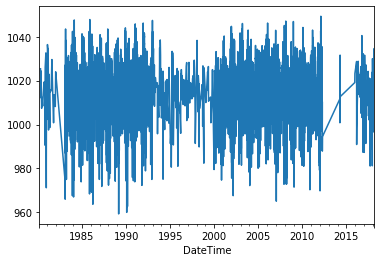

In [13]:
df['Esbjerg']['Pressure'].plot()

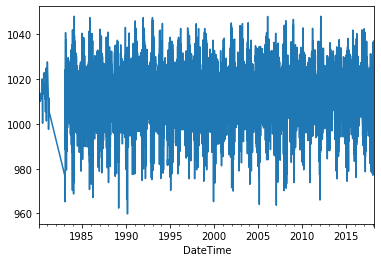

In [14]:
df['Roskilde']['Pressure'].plot()

In [15]:
df.values.shape

(333109, 20)

In [0]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

In [17]:
df.values.shape

(333109, 18)

In [18]:
df.head(1)

Aalborg                         ... Roskilde                   
                       Temp     Pressure WindSpeed  ...     Temp  WindSpeed WindDir
DateTime                                            ...                            
1980-03-01 11:00:00     5.0  1007.766667      10.2  ...      5.0  11.466667   280.0

[1 rows x 18 columns]

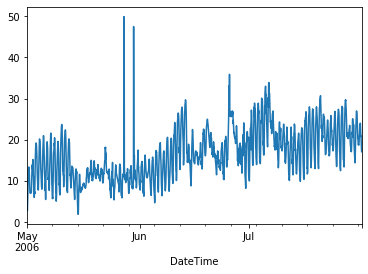

In [19]:
df['Odense']['Temp']['2006-05':'2006-07'].plot()

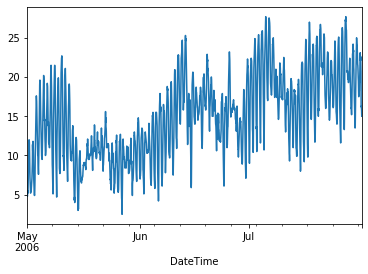

In [20]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot()

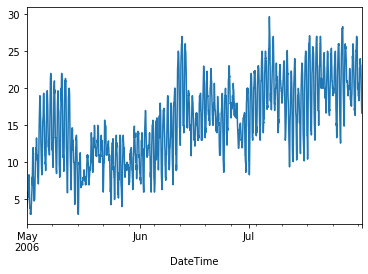

In [21]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot()

In [0]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [0]:
target_city = 'Odense'

In [0]:
target_names = ['Temp', 'WindSpeed', 'Pressure']

In [0]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [0]:
df_targets = df[target_city][target_names].shift(-shift_steps)

In [27]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


In [28]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


In [29]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


In [0]:
x_data = df.values[0:-shift_steps]

In [31]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


In [0]:
y_data = df_targets.values[:-shift_steps]

In [33]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


In [34]:
num_data = len(x_data)
num_data

333085

In [0]:
train_split = 0.9

In [36]:
num_train = int(train_split * num_data)
num_train

299776

In [37]:
num_test = num_data - num_train
num_test

33309

In [38]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

In [39]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

In [40]:
num_x_signals = x_data.shape[1]
num_x_signals

20

In [41]:
num_y_signals = y_data.shape[1]
num_y_signals

3

In [42]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


In [0]:
x_scaler = MinMaxScaler()

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [45]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))


Min: 0.0
Max: 1.0000000000000002


In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [48]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 256

In [51]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [54]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


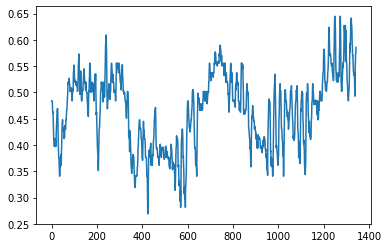

In [55]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

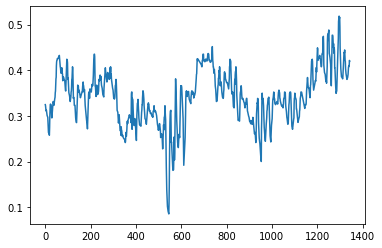

In [56]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
model = Sequential()

In [59]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [0]:
optimizer = RMSprop(lr=1e-3)

In [65]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         818688    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 820,227
Trainable params: 820,227
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [73]:
%%time
model.fit_generator(generator=generator,
                    epochs=5,
                    steps_per_epoch=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
 1/10 [==>...........................] - ETA: 1:12 - loss: 0.0047
Epoch 00001: val_loss improved from inf to 0.00475, saving model to 23_checkpoint.keras
10/10 [==============================] - 27s 3s/step - loss: 0.0081 - val_loss: 0.0047
Epoch 2/5
 1/10 [==>...........................] - ETA: 1:11 - loss: 0.0075
Epoch 00002: val_loss did not improve from 0.00475

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10/10 [==============================] - 26s 3s/step - loss: 0.0064 - val_loss: 0.0075
Epoch 3/5
 1/10 [==>...........................] - ETA: 1:11 - loss: 0.0043
Epoch 00003: val_loss improved from 0.00475 to 0.00431, saving model to 23_checkpoint.keras
10/10 [==============================] - 26s 3s/step - loss: 0.0059 - val_loss: 0.0043
Epoch 4/5
 1/10 [==>...........................] - ETA: 1:12 - loss: 0.0041
Epoch 00004: val_loss improved from 0.00431 to 0.00412, saving model to 23_checkpoint.keras
10/10 [=======================

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [75]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 8s 8s/sample - loss: 0.0039


In [76]:
print("loss (test-set):", result)

loss (test-set): 0.0038967959117144346


In [0]:

# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

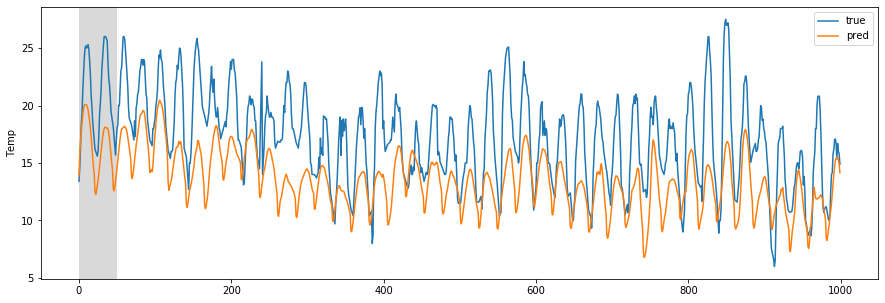

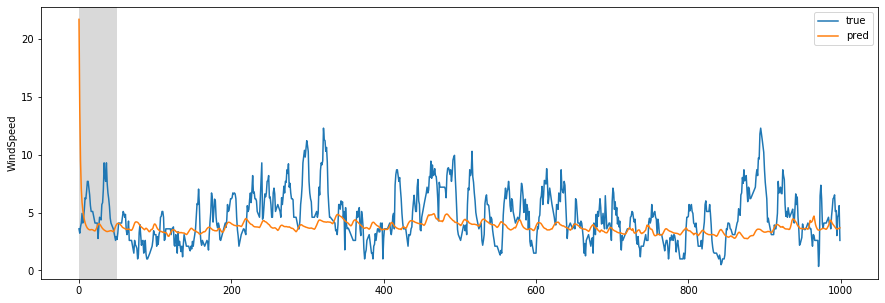

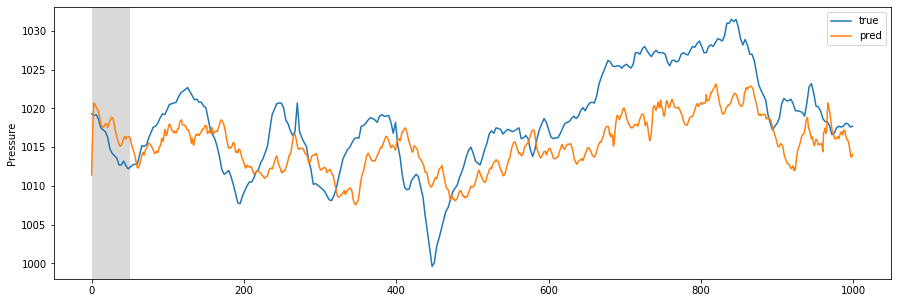

In [79]:
plot_comparison(start_idx=100000, length=1000, train=True)

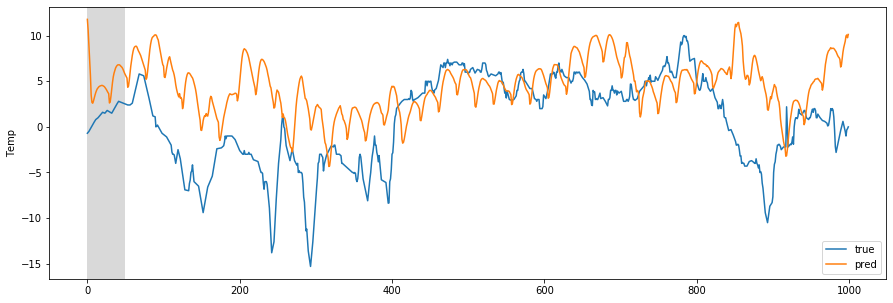

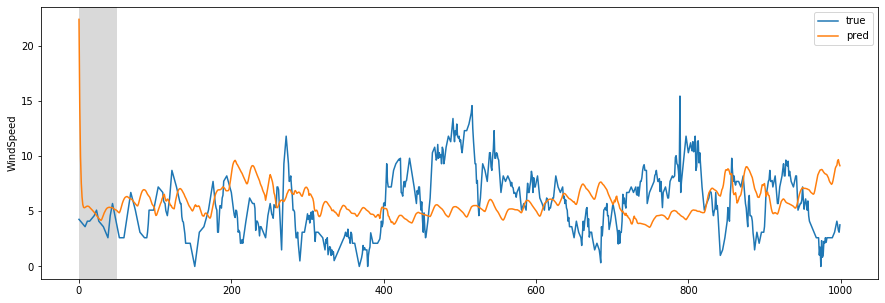

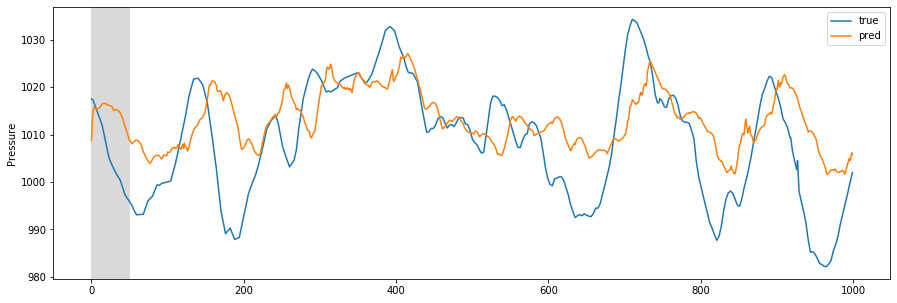

In [80]:
plot_comparison(start_idx=200000, length=1000, train=True)

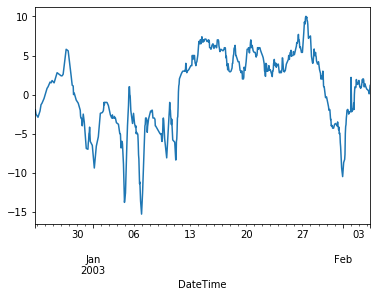

In [81]:
df['Odense']['Temp'][200000:200000+1000].plot()

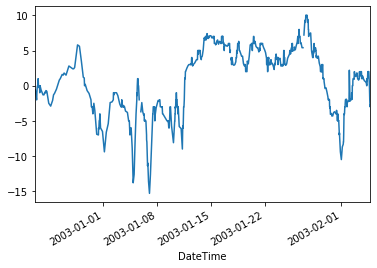

In [82]:

df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot()

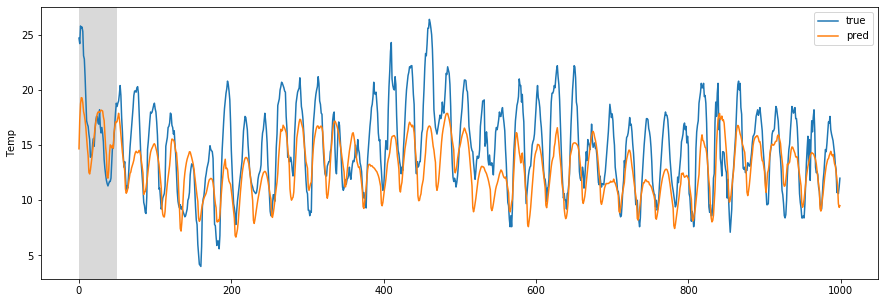

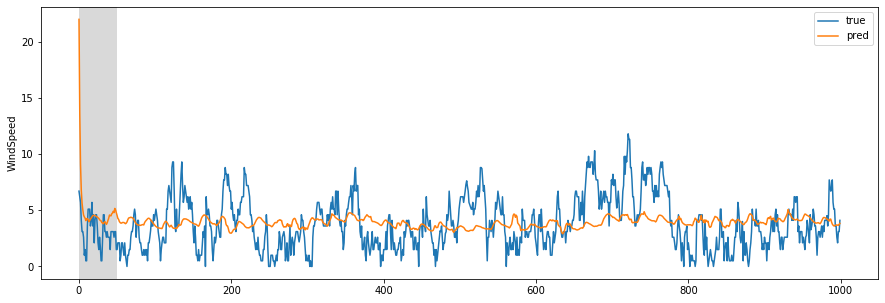

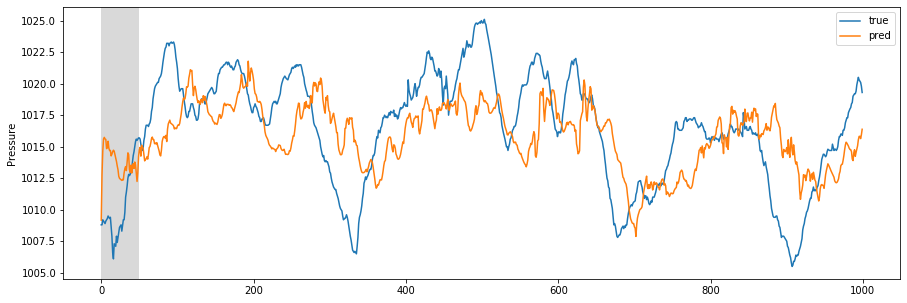

In [83]:
plot_comparison(start_idx=200, length=1000, train=False)